In [18]:
import pickle 
import torch as th
from torch_geometric.explain import Explainer, CaptumExplainer
import torch.nn.functional as F
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
with open('interm/BoT-IoT_reduced_graph.pkl', 'rb') as f:
    G = pickle.load(f)

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [20]:
G_line = G.line_graph(shared=True)

In [21]:
G_line.number_of_nodes(), G_line.number_of_edges()

(148792, 134710628)

In [22]:
from torch_geometric.utils import from_dgl

# train mask
pyG_line = from_dgl(G_line)
nodes = G_line.number_of_nodes()

train_amount = int(0.8*nodes)
perm = torch.randperm(nodes)
train_idx = perm[:train_amount]
test_idx = perm[train_amount:]

pyG_line.train_mask = torch.zeros(nodes, dtype=torch.bool)
pyG_line.train_mask[train_idx] = True
pyG_line.test_mask = ~pyG_line.train_mask

In [23]:
import pandas as pd 

with open('interm/BoT-IoT_reduced_linegraph_jul29.pkl', 'wb') as f:
    pickle.dump(pyG_line, f)

In [24]:
from torch_geometric.loader import NeighborLoader
import numpy as np 

loader = NeighborLoader(
    pyG_line,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=True,
    num_workers=6,
    input_nodes=pyG_line.train_mask
)

test_loader = NeighborLoader(
    pyG_line,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=True,
    num_workers=6,
    input_nodes=pyG_line.test_mask
)

print(len(loader), len(test_loader))

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


930 233


In [25]:
import gc
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn.models.basic_gnn import GraphSAGE

g = pyG_line

model = GraphSAGE(
    49,
    hidden_channels=256,
    out_channels=5,
    num_layers=3,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_epoch(model, train_loader, test_loader):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        batch = batch.to(device)   
        out= model( batch.x.to(device), batch.edge_index.to(device))
        out = out[:batch.batch_size]
        y = batch.Attack[:batch.batch_size]

        loss = F.cross_entropy(out, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        del batch
        
    model.eval()
    total_test_loss = 0
    for batch in tqdm(test_loader):
        with torch.no_grad():
            out = model(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            y = batch.Attack[:batch.batch_size]
            total_test_loss += F.cross_entropy(out, y)
        
        del batch
        
    return total_loss / len(train_loader), total_test_loss / len(test_loader)

loss, test_loss = train_epoch(model, loader, test_loader)


100%|██████████| 233/233 [00:12<00:00, 18.67it/s]


In [26]:
loss, test_loss

(0.2832546352258613, tensor(0.1321))

epoch: 1/5


100%|██████████| 233/233 [00:12<00:00, 18.72it/s]


0.1899357010360046 tensor(0.1272)
epoch: 2/5


100%|██████████| 233/233 [00:12<00:00, 18.27it/s]


0.12792515023060705 tensor(0.1385)
epoch: 3/5


100%|██████████| 233/233 [00:12<00:00, 19.34it/s]


0.1236182004934357 tensor(0.1130)


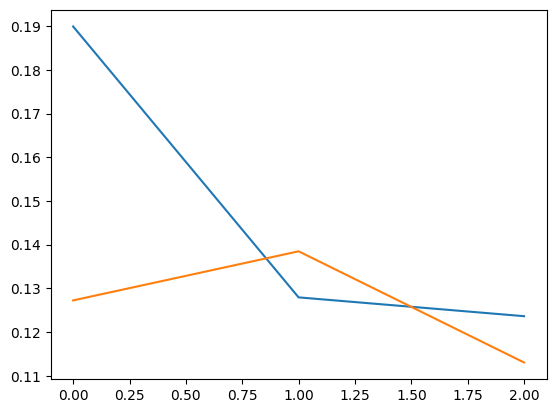

In [ ]:
import matplotlib.pyplot as plt
import os

l, tl = [], []
for epoch in range(3):
    print(f'epoch: {epoch+1}/3')
    loss, test_loss = train_epoch(model, loader, test_loader)
    l.append(loss)
    tl.append(test_loss)
    print(loss, test_loss)
    
plt.plot(l)
plt.plot(tl)
plt.show()

In [28]:
from sklearn.metrics import classification_report

def evaluate(model, test_loader, digits=4):
    model.eval()
    total_test_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            out = out[:batch.batch_size]
            y = batch.Attack[:batch.batch_size]

            preds = out.argmax(dim=1)
            y_true.append(y.cpu())
            y_pred.append(preds.cpu())
            total_test_loss += F.cross_entropy(out, y).item()
            del batch

    # Flatten all batches
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    return classification_report(y_true, y_pred, digits=digits)


cr = evaluate(model, test_loader)
print("\n🧾 Classification Report:")
print(cr)

100%|██████████| 233/233 [00:12<00:00, 19.02it/s]


🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9915    0.9993    0.9954     22968
           1     0.6729    0.7389    0.7044      2099
           2     0.7160    0.6459    0.6792      2073
           3     0.9967    0.9159    0.9546      1998
           4     0.9983    0.9630    0.9803       621

    accuracy                         0.9500     29759
   macro avg     0.8751    0.8526    0.8628     29759
weighted avg     0.9504    0.9500    0.9498     29759



In [30]:
th.save(model.state_dict(), 'interm/GraphSAGE_BoTIoT.pth')